Epoch 1/30


/Users/yasharya/PycharmProjects/Synthetic-Data/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.3490 - val_loss: 0.9477
Epoch 2/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8915 - val_loss: 0.9718
Epoch 3/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9037 - val_loss: 0.9879
Epoch 4/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9300 - val_loss: 1.0714
Epoch 5/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9608 - val_loss: 1.0430
Epoch 6/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9278 - val_loss: 0.9994
Epoch 7/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9261 - val_loss: 1.0194
Epoch 8/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9645 - val_loss: 1.0268
Epoch 9/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9550 - val_loss: 1.0454
Epoch 10/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9568 - val_loss: 1.0740
Epoch 11/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9739 - val_loss: 1.0280
Epoch 12/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0

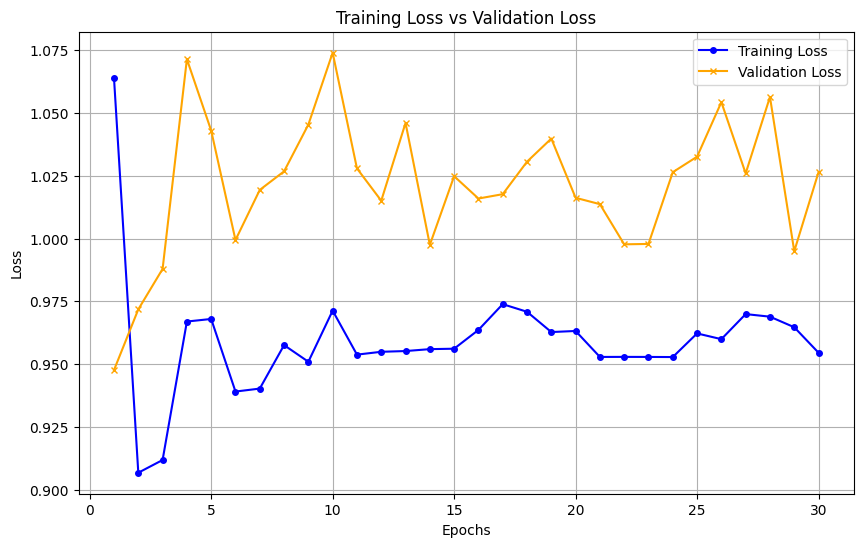

 50/585 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

/Users/yasharya/PycharmProjects/Synthetic-Data/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step
[[-0.20118791]
 [-0.18149792]
 [-0.2012722 ]
 ...
 [-0.20739648]
 [-0.229253  ]
 [-0.19721042]]
18711


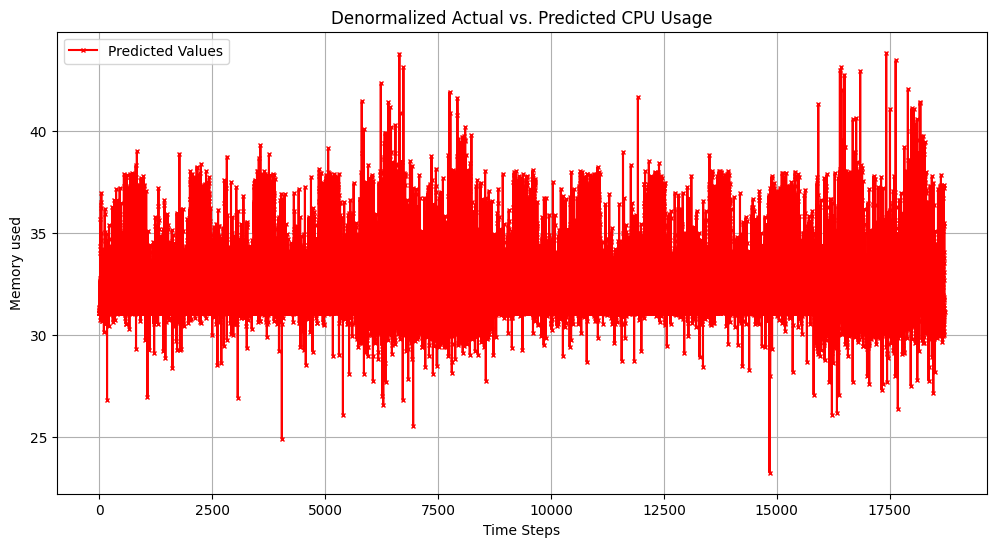

In [2]:
import pandas as pd
import numpy as np
# 
# # Load the data
# data_all = pd.read_csv('./Output_Data/normalizedvmCloud_data.csv')
# data = data_all.head(200000)
# 
# # Check for NaN values
# print(data.isna().sum())
# 
# # Fill or drop NaN values if any
# data = data.fillna(method='ffill').fillna(method='bfill')  # Forward and backward fill
# 
# # Ensure no infinite values
# data = data.replace([np.inf, -np.inf], np.nan).dropna()
# 
# print(data.size)
from sklearn.preprocessing import StandardScaler

# Load your dataframe
data = pd.read_csv('./Output_Data/normalized_cloud_usage.csv')

# Features and target (CPU usage only)
features = ["cpu_usage", "memory_usage", "network_bandwidth_mbps",
            "api_requests_per_second", "concurrent_users"]
# features = ["cpu_usage","memory_usage","network_traffic","power_consumption","num_executed_instructions","execution_time","energy_efficiency"]

# Initialize scaler and fit on the features (fit only on training data!)
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Save the scaler for denormalization later
import joblib

joblib.dump(scaler, 'scaler.pkl')

# Create inputs (X) and output (y) for training
X = data[features].values  # Input: all features
y = data["cpu_usage"].values  # Target: CPU usage only

# Reshape the input data for LSTM (samples, timesteps, features)
timesteps = 10  # Adjust the sequence length as needed
X_lstm = np.array([X[i:i + timesteps] for i in range(len(X) - timesteps)])
y_lstm = y[timesteps:]  # Shifted target to match sequence length

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(50))
model.add(Dropout(0.1))
model.add(Dense(1))  # Output layer to predict a single value (CPU usage)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')

# Train the model
history = model.fit(X_lstm, y_lstm, epochs=30, batch_size=128, validation_split=0.2)

import matplotlib.pyplot as plt

# Extract training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array for the epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o', markersize=4)
plt.plot(epochs, val_loss, label='Validation Loss', color='orange', marker='x', markersize=4)

# Add title and labels
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()
# Normalize test data using the same scaler
X_test_normalized = scaler.transform(data[features].values)

# Reshape for LSTM input (matching the training shape)
X_test_lstm = np.array([X_test_normalized[i:i + timesteps]
                        for i in range(len(X_test_normalized) - timesteps)])

# Make predictions
predictions = model.predict(X_test_lstm)

# count = 0
# for x in predictions:
#     predictions[count] = ((150/100)*x) + x
#     count+= 1

# Load the scaler and extract the mean & std for CPU usage
scaler = joblib.load('scaler.pkl')
mean = [33.37259751, 59.99191496, 500.59977334, 202.01394156, 78.5070242]
# usage is the first feature
std = [11.39790946, 7.98941626, 100.1715581, 43.55748615, 33.49994346]

# Denormalize the predicted CPU usage
# denormalized_predictions= (predictions * std) + mean
# 
# # Display predictions
# print(denormalized_predictions)
print(predictions)
print(np.size(predictions, axis=0))
import matplotlib.pyplot as plt
import numpy as np

# Ensure predictions and actual values are properly shaped
normalized_predictions = np.squeeze(predictions)  # Remove extra dimensions if necessary
y_true_normalized = y_lstm[timesteps:timesteps + len(normalized_predictions)]  # Align lengths

# # Plot the normalized predictions vs actual values
# plt.figure(figsize=(10, 6))
# plt.plot(y_true_normalized, label='Actual (Normalized)', color='blue', marker='o', markersize=3)
# plt.plot(normalized_predictions, label='Predicted (Normalized)', color='red', marker='x', markersize=3)
# 
# # Adding labels and title
# plt.xlabel('Time Steps')
# plt.ylabel('CPU Usage (Normalized)')
# plt.title('Normalized Predictions vs Actual Values')
# plt.legend()
# plt.grid(True)
# 
# # Display the plot
# plt.show()

import numpy as np
import matplotlib.pyplot as plt

# Assume you have the following variables:
# predictions: the normalized predictions from your model
# y_lstm: the actual normalized values (for the same time steps)
# mean and std values for denormalization

# Replace these with your actual mean and std values
mean_values = np.array(mean[0])  # Mean of CPU usage
std_values = np.array(std[0])  # Standard deviation of CPU usage

# Denormalize the predictions
denormalized_predictions = predictions * std_values + mean_values

# Denormalize the actual values
denormalized_actual = y_lstm[timesteps:timesteps + len(denormalized_predictions)]  # Adjust this as needed
denormalized_actual = (denormalized_actual * std_values) + mean_values

# Plotting the denormalized values
plt.figure(figsize=(12, 6))
# plt.plot(denormalized_actual, label='Actual Values', color='blue', marker='o', markersize=3)
plt.plot(denormalized_predictions, label='Predicted Values', color='red', marker='x', markersize=3)

# Add labels and title
plt.title('Denormalized Actual vs. Predicted CPU Usage')
plt.xlabel('Time Steps')
plt.ylabel('Memory used')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

model.save('Model/finalModelv2.keras')